# Usar um pipeline para ler e processar um conjunto de ficheiros e usar esse mesmo pipeline como 'conjunto de treino' #

In [1]:
import glob
import numpy as np
import tensorflow as tf
import numpy

In [5]:
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/ADNE/Dados/trainAlunos/'
list_npy_files = glob.glob(dir + '*.npy')
train_dataset = tf.data.Dataset.from_tensor_slices(list_npy_files)

dir = '/content/drive/MyDrive/ADNE/Dados/validacaoAlunos/'
list_npy_files = glob.glob(dir + '*.npy')
validation_dataset = tf.data.Dataset.from_tensor_slices(list_npy_files)

dirteste = '/content/drive/MyDrive/ADNE/Dados/testeAlunos/'
list_npy_files = glob.glob(dirteste + '*.npy')
test_dataset = tf.data.Dataset.from_tensor_slices(list_npy_files)


Mounted at /content/drive


In [3]:
def read_npy(fname):
    """fname should be a npy file"""
    fname = fname.decode()
    recData = np.load(fname)
    return recData.astype(np.float32)

In [4]:
train_dataset = train_dataset.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
validation_dataset = validation_dataset.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))
test_dataset = test_dataset.map(lambda x: tf.numpy_function(read_npy, [x], [tf.float32]))

train_dataset_full = train_dataset
validation_dataset_full = validation_dataset

In [6]:
L=2000
def randomExtract(x):
    length = tf.shape(x)[1]
    init = tf.random.uniform([], minval=0,maxval=length-L,dtype=tf.dtypes.int32)
    return x[:, init:init+L]

In [7]:

dataset_train= train_dataset.map(lambda x: randomExtract(x))
dataset_validation= validation_dataset.map(lambda x: randomExtract(x))
#dataset_test= test_dataset.map(lambda x: randomExtract(x))





In [8]:
split_train=dataset_train.map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))
split_val=dataset_validation.map(lambda x: (tf.math.abs(tf.signal.stft(x[0], 256, 128)),x[1]))

split_test=test_dataset.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))

split_train_full=train_dataset_full.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))
split_val_full=validation_dataset_full.map(lambda x: ((tf.shape(x)[1],tf.math.abs(tf.signal.stft(x[0], 64, 32))),x[1]))


In [9]:
shapes = (([], tf.TensorShape([None,33])), [None])

train_data=split_train.batch(250)
val_data=split_val.batch(250)

test_data=split_test.padded_batch(1, shapes)

train_data_full = split_train_full.padded_batch(50, shapes)
val_data_full=split_val_full.padded_batch(50, shapes)

# **FEED FOWARD**

In [ ]:
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv1D,MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, UpSampling1D, Input
from tensorflow.keras.optimizers import SGD, Adam

model = keras.models.Sequential()

model.add(Flatten(input_shape=(14,129)))
model.add(Dense(4000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())

model.add(Reshape((200,5)))
model.add(UpSampling1D(size=10))
model.add(Dropout(0.2))
model.add(Activation("softmax"))

NUM_EPOCHS = 200
#INIT_LR = 0.0001
#opt = SGD(nesterov=False,learning_rate=INIT_LR, momentum=0.9, decay=.1)
opt=Adam()
model.compile(metrics = ['sparse_categorical_accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt)

#model.summary()
plot_model(model, to_file='model_FF.png', show_shapes=True)

history = model.fit(train_data, validation_data=val_data, epochs=NUM_EPOCHS)

model.summary()


Epoch 1/200
10/10 [==============================] - 522s 52s/step - loss: 1.5438 - sparse_categorical_accuracy: 0.3848 - val_loss: 5.9856 - val_sparse_categorical_accuracy: 0.2150
Epoch 2/200
10/10 [==============================] - 7s 739ms/step - loss: 1.2772 - sparse_categorical_accuracy: 0.5344 - val_loss: 3.4857 - val_sparse_categorical_accuracy: 0.3275
Epoch 3/200
10/10 [==============================] - 7s 678ms/step - loss: 1.1580 - sparse_categorical_accuracy: 0.5945 - val_loss: 2.0639 - val_sparse_categorical_accuracy: 0.4973
Epoch 4/200
10/10 [==============================] - 7s 694ms/step - loss: 1.1128 - sparse_categorical_accuracy: 0.6076 - val_loss: 1.2476 - val_sparse_categorical_accuracy: 0.6173
Epoch 5/200
10/10 [==============================] - 7s 677ms/step - loss: 1.0758 - sparse_categorical_accuracy: 0.6192 - val_loss: 1.0824 - val_sparse_categorical_accuracy: 0.6593
Epoch 6/200
10/10 [==============================] - 7s 685ms/step - loss: 1.0401 - sparse_cate

Training and Validation Plots and Values

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


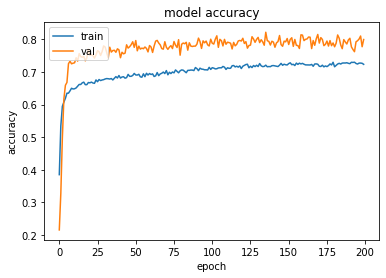

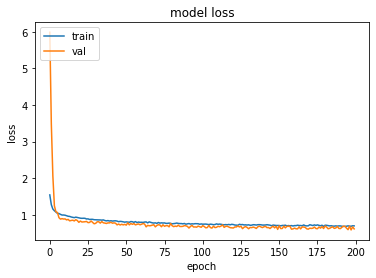

Train Accuracy
0.7300242185592651
Validation Accuracy
0.8220122456550598
Train Loss
0.684510350227356
Validation Loss
0.5884000062942505


In [ ]:
print(history.history.keys())
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("Train Accuracy")
print(numpy.max(history.history['sparse_categorical_accuracy']))
print("Validation Accuracy")
print(numpy.max(history.history['val_sparse_categorical_accuracy']))
print("Train Loss")
print(numpy.min(history.history['loss']))
print("Validation Loss")
print(numpy.min(history.history['val_loss']))

Predict Function

In [ ]:
readNump=np.load(dirteste + "49631_AV_sigTarg.npy")
#readNump=np.load(dirteste + "50807_PV_sigTarg.npy")
readNumpX = readNump[0]

splitSize = 2000
splitNump = [readNumpX[x:x+splitSize] for x in range(0, len(readNumpX), splitSize)]
splitNump[-1] = np.append(splitNump[-1], np.zeros(splitSize-len(splitNump[-1])))

arrayF = []
for i in splitNump:
  arrayF.append(tf.math.abs(tf.signal.stft(i,256,128)))

batchEx = np.array(arrayF)
predict = model.predict(batchEx)

predictArgMax = tf.argmax(predict,axis=-1)
atributos = readNumpX
print("Atributos"+str(atributos))

Atributos[  281. -1174. -1942. ... -3357.  1983.  4854.]


Predict Graph

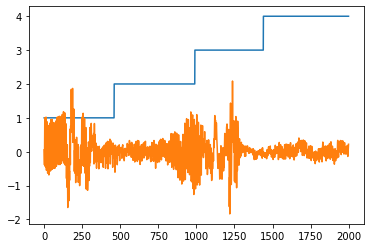

In [ ]:
plt.plot(predictArgMax[0][:2000])
plt.plot(readNumpX[0:2000]/5000)
plt.show()

# **CONVOLUTIONAL**

In [ ]:
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv1D,MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, UpSampling1D, Input, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import SGD, Adam

input_1 = Input(shape=[], name='cutting_layer')
input_ = Input(shape=(None,33))

layer = Conv1D(64,kernel_size=3, activation='ReLU')(input_)
layer = BatchNormalization()(layer)
#layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(64,kernel_size=3, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
#layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(64,kernel_size=3, padding="same",activation='ReLU')(layer)
layer = BatchNormalization()(layer)
#layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(128,kernel_size=3, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
#layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

p=35
layer = TimeDistributed(Dense(p))(layer)
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=(100))(layer)
A=tf.reduce_max(input_1)
A=tf.cast(A,tf.int32)
print(A)
layer = layer[:,:A]
layer = SpatialDropout1D(0.3)(layer)
layer = Activation("softmax")(layer)

model = keras.Model(inputs=([input_1, input_]), outputs=layer)

plot_model(model, to_file='model_Conv.png', show_shapes=True)


#O=model(ex3[0])
#print(O)

INIT_LR = 0.0001
NUM_EPOCHS = 50
#opt = SGD(learning_rate=INIT_LR)
opt=Adam()
model.compile(metrics = ['sparse_categorical_accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt)

model.summary()

history = model.fit(train_data_full, validation_data=val_data_full, epochs=NUM_EPOCHS)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.cast/Cast:0', description="created by layer 'tf.cast'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 33)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     6400        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, 64)    256         ['conv1d[0][0]']                 
 ormalization)                                                                                    
                                  

Training and Validation Plots and Values

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


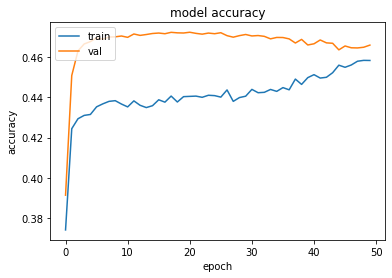

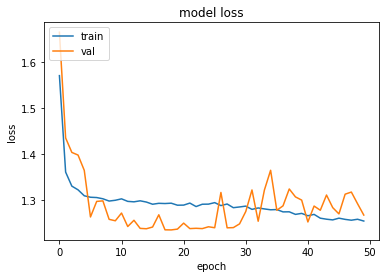

val accuracy: 
0.4723884165287018
accuracy: 
0.4583941698074341
val loss: 
1.2347544431686401
train loss: 
1.2540472745895386


In [ ]:
print(history.history.keys())
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("val accuracy: ")
print(numpy.max(history.history['val_sparse_categorical_accuracy']))
print("accuracy: ")
print(numpy.max(history.history['sparse_categorical_accuracy']))
print("val loss: ")
print(numpy.min(history.history['val_loss']))
print("train loss: ")
print(numpy.min(history.history['loss']))

Test Loss and Accuracy

In [ ]:
loss,accuracy = model.evaluate(test_data)
print("Loss: "+str(loss))
print("Accuracy: "+str(accuracy))

286/286 [==============================] - 41s 143ms/step - loss: 1.4740 - sparse_categorical_accuracy: 0.3894
Loss: 1.4739576578140259
Accuracy: 0.3894118368625641


In [ ]:
def predictConv(NumpArray):
  FourierTransf = tf.math.abs(tf.signal.stft(NumpArray,64,32))
  input = (np.array([NumpArray.shape[0]]),np.array([FourierTransf]))
  prev = model.predict(input)
  return prev
filename = "49631_AV_sigTarg.npy"
read = np.load(dirteste+filename)
atributos = read[0]
print("Atributos"+str(atributos))

predic = predictConv(atributos)
print(predic)
previsaoArgMax=tf.argmax(predic,axis=-1)

Atributos[  281. -1174. -1942. ... -3357.  1983.  4854.]
[[[0.00953275 0.06378359 0.06190815 0.18587334 0.6789021 ]
  [0.00953275 0.06378359 0.06190815 0.18587334 0.6789021 ]
  [0.00953275 0.06378359 0.06190815 0.18587334 0.6789021 ]
  ...
  [0.19853213 0.20610018 0.2119317  0.15682903 0.22660698]
  [0.19853213 0.20610018 0.2119317  0.15682903 0.22660698]
  [0.19853213 0.20610018 0.2119317  0.15682903 0.22660698]]]


Predict Graph

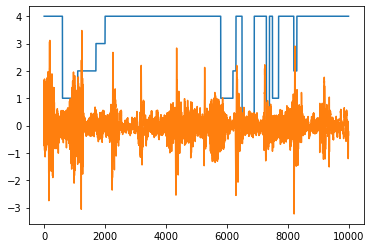

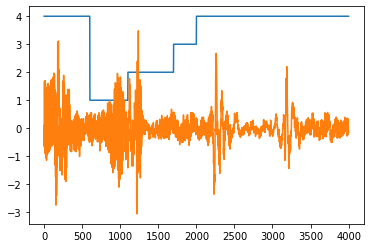

In [ ]:
plt.plot(previsaoArgMax[0][:10000])
plt.plot(atributos[0:10000]/3000)
plt.show()

plt.plot(previsaoArgMax[0][:4000])
plt.plot(atributos[0:4000]/3000)
plt.show()

# **RECURRENT**

In [ ]:
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv1D,MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, UpSampling1D, Input, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import SGD, Adam


input_1 = Input(shape=[], name='cutting_layer')
input_ = Input(shape=(None,33))
#input_2 = Dense(500,activation='ReLU')(input_)

layer = Conv1D(32,kernel_size=3, activation='ReLU')(input_)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.3)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(64,kernel_size=3, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.3)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(128,kernel_size=3, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.3)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(128,kernel_size=4, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.3)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(layer)
#layer = SpatialDropout1D(0.3)(layer)
#layer = LSTM(128, return_sequences=True)(layer)
layer = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(layer)


p=35
layer = TimeDistributed(Dense(p))(layer)
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=(100))(layer)
A=tf.reduce_max(input_1)
A=tf.cast(A,tf.int32)
print(A)
layer = layer[:,:A]
layer = SpatialDropout1D(0.3)(layer)
layer = Activation("softmax")(layer)




model = keras.Model(inputs=([input_1, input_]), outputs=layer)


plot_model(model, to_file='model_Conv_1.png', show_shapes=True)


#O=model(ex3[0])
#print(O)

INIT_LR = 0.0001
NUM_EPOCHS = 100
#opt = SGD(learning_rate=INIT_LR)
opt=Adam()
model.compile(metrics = ['sparse_categorical_accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt)


model.summary()

history = model.fit(train_data_full, validation_data=val_data_full, epochs=NUM_EPOCHS)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.cast_1/Cast:0', description="created by layer 'tf.cast_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 33)]   0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, None, 32)     3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, None, 32)    128         ['conv1d_4[0][0]']               
 rmalization)                                                                                     
                            

Training and Validation Plots and Values

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


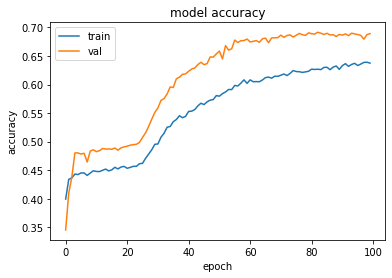

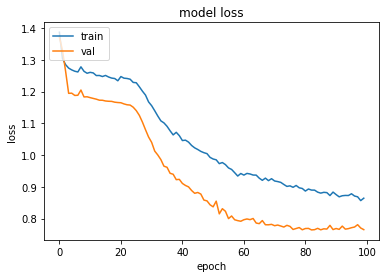

val accuracy: 
0.6915233731269836
accuracy: 
0.638980507850647
val loss: 
0.7643119692802429
train loss: 
0.8566975593566895


In [ ]:
print(history.history.keys())
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("val accuracy: ")
print(numpy.max(history.history['val_sparse_categorical_accuracy']))
print("accuracy: ")
print(numpy.max(history.history['sparse_categorical_accuracy']))
print("val loss: ")
print(numpy.min(history.history['val_loss']))
print("train loss: ")
print(numpy.min(history.history['loss']))

Test Loss and Accuracy

In [ ]:
loss,accuracy = model.evaluate(test_data)
print("Loss: "+str(loss))
print("Accuracy: "+str(accuracy))

286/286 [==============================] - 67s 232ms/step - loss: 0.8572 - sparse_categorical_accuracy: 0.6343
Loss: 0.8572496771812439
Accuracy: 0.6342942714691162


In [ ]:
def predictConv(NumpArray):
  FourierTransf = tf.math.abs(tf.signal.stft(NumpArray,64,32))
  input = (np.array([NumpArray.shape[0]]),np.array([FourierTransf]))
  prev = model.predict(input)
  return prev
filename = "49631_AV_sigTarg.npy"
filename = "50807_PV_sigTarg.npy"
print(dirteste)
read = np.load(dirteste+filename)
atributos = read[0]
print("Atributos"+str(atributos))

predic = predictConv(atributos)
print(predic)
previsaoArgMax=tf.argmax(predic,axis=-1)

Predict Graphs

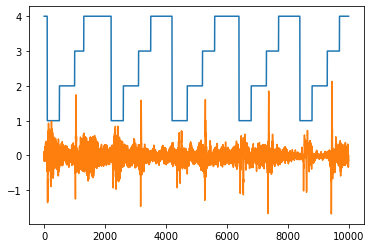

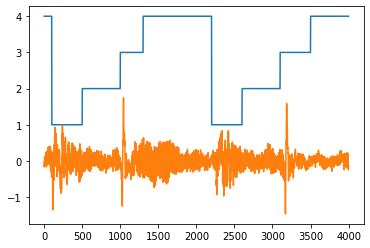

In [ ]:
plt.plot(previsaoArgMax[0][:10000])
plt.plot(atributos[0:10000]/3000)
plt.show()

plt.plot(previsaoArgMax[0][:4000])
plt.plot(atributos[0:4000]/3000)
plt.show()

# **TRANSFORMER**

In [10]:
from tensorflow.keras import layers

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[1]
        batchS = tf.shape(x)[0]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        positions = tf.expand_dims(positions, axis = 0)
        positions = tf.repeat(positions, batchS, axis=0)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv1D,MaxPooling2D, TimeDistributed, SpatialDropout1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Reshape, UpSampling1D, Input, LSTM
from tensorflow.keras.optimizers import SGD, Adam


input_1 = Input(shape=[], name='tenta')
input_ = Input(shape=(None,33))
layer = Conv1D(32,kernel_size=2, activation='ReLU')(input_)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(64,kernel_size=3, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = Conv1D(128,kernel_size=4, activation='ReLU')(layer)
layer = BatchNormalization()(layer)
layer = SpatialDropout1D(0.2)(layer)
layer = MaxPooling1D(pool_size=2)(layer)

layer = LSTM(128,return_sequences=True,recurrent_dropout=0.1)(layer)

embDim = 20
layer = layers.TimeDistributed(layers.Dense(embDim))(layer)
layer = PositionEmbedding(maxlen=2000, embed_dim=embDim)(layer)
layer = TransformerBlock(embed_dim=embDim,num_heads=6, ff_dim=16)(layer)
layer =TransformerBlock(embed_dim=embDim,num_heads=6, ff_dim=16)(layer)

p=35
layer = TimeDistributed(Dense(p))(layer)
layer = Reshape((-1,5))(layer)
layer = UpSampling1D(size=(60))(layer)
A=tf.reduce_max(input_1)
A=tf.cast(A,tf.int32)
print(A)
layer = layer[:,:A]
layer = Activation("softmax")(layer)

model = keras.Model(inputs=([input_1, input_]), outputs=layer)

plot_model(model, to_file='model_Transf.png', show_shapes=True)

NUM_EPOCHS = 100
#INIT_LR = 0.01
#opt = SGD(learning_rate=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
opt=Adam()
model.compile(metrics = ['sparse_categorical_accuracy'],loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt)

model.summary()

history = model.fit(train_data_full, validation_data=val_data_full, epochs=NUM_EPOCHS)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.cast_1/Cast:0', description="created by layer 'tf.cast_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 33)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, None, 32)     2144        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, None, 32)    128         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                            

Training and Validation Plots and Values

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


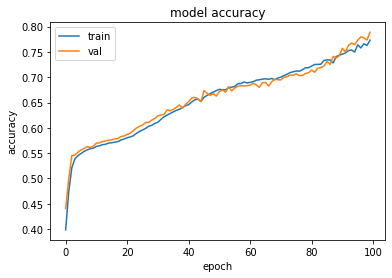

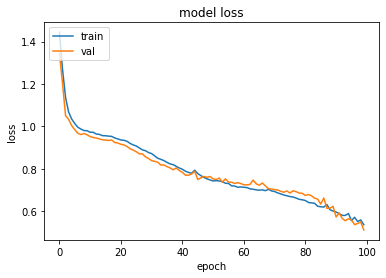

val accuracy: 
0.7888348698616028
accuracy: 
0.7731264233589172
val loss: 
0.512377142906189
train loss: 
0.5368317365646362


In [13]:
print(history.history.keys())
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print("val accuracy: ")
print(numpy.max(history.history['val_sparse_categorical_accuracy']))
print("accuracy: ")
print(numpy.max(history.history['sparse_categorical_accuracy']))
print("val loss: ")
print(numpy.min(history.history['val_loss']))
print("train loss: ")
print(numpy.min(history.history['loss']))

Test Loss and Accuracy

In [14]:
loss,accuracy = model.evaluate(test_data)
print("Loss: "+str(loss))
print("Accuracy: "+str(accuracy))

286/286 [==============================] - 61s 213ms/step - loss: 0.7592 - sparse_categorical_accuracy: 0.6840
Loss: 0.7592283487319946
Accuracy: 0.6839936375617981


In [ ]:
def predictConv(NumpArray):
  FourierTransf = tf.math.abs(tf.signal.stft(NumpArray,64,32))
  input = (np.array([NumpArray.shape[0]]),np.array([FourierTransf]))
  prev = model.predict(input)
  return prev
filename = "49631_AV_sigTarg.npy"
#filename = "50807_PV_sigTarg.npy"
print(dirteste)
read = np.load(dirteste+filename)
atributos = read[0]
print("Atributos"+str(atributos))

predic = predictConv(atributos)
print(predic)
previsaoArgMax=tf.argmax(predic,axis=-1)
print(previsaoArgMax)

In [ ]:
plt.plot(previsaoArgMax[0][:10000])
plt.plot(atributos[0:10000]/3000)
plt.show()

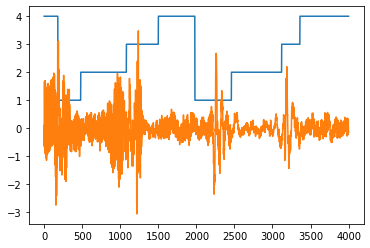

In [17]:
plt.plot(previsaoArgMax[0][:4000])
plt.plot(atributos[0:4000]/3000)
plt.show()